Device info: UnitInfo(driver=<picosdk.ps2000.Ps2000lib object at 0x7fef2ad03e20>, variant=b'2205A', serial=b'EY451/364')


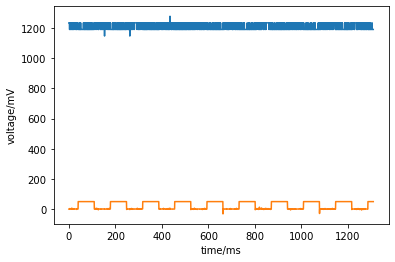

In [12]:
from ctypes import byref, c_byte, c_int16, c_int32, sizeof
from time import sleep

from picosdk.ps2000 import ps2000
from picosdk.functions import assert_pico2000_ok, adc2mV
from picosdk.PicoDeviceEnums import picoEnum

import matplotlib.pyplot as plt


SAMPLES = 2000
OVERSAMPLING = 1


def get_timebase(device, wanted_time_interval):
    current_timebase = 1

    old_time_interval = None
    time_interval = c_int32(0)
    time_units = c_int16()
    max_samples = c_int32()

    while ps2000.ps2000_get_timebase(
        device.handle,
        current_timebase,
        2000,
        byref(time_interval),
        byref(time_units),
        1,
        byref(max_samples)) == 0 \
        or time_interval.value < wanted_time_interval:

        current_timebase += 1
        old_time_interval = time_interval.value

        if current_timebase.bit_length() > sizeof(c_int16) * 8:
            raise Exception('No appropriate timebase was identifiable')

    return current_timebase - 1, old_time_interval


with ps2000.open_unit() as device:
    print('Device info: {}'.format(device.info))

    res = ps2000.ps2000_set_channel(
        device.handle,
        picoEnum.PICO_CHANNEL['PICO_CHANNEL_A'],
        True,
        picoEnum.PICO_COUPLING['PICO_DC'],
        ps2000.PS2000_VOLTAGE_RANGE['PS2000_500MV'],
    )
    assert_pico2000_ok(res)

    res = ps2000.ps2000_set_channel(
        device.handle,
        picoEnum.PICO_CHANNEL['PICO_CHANNEL_B'],
        True,
        picoEnum.PICO_COUPLING['PICO_DC'],
        ps2000.PS2000_VOLTAGE_RANGE['PS2000_50MV'],
    )
    assert_pico2000_ok(res)

    timebase_a, interval = get_timebase(device, 800_000)

    collection_time = c_int32()

    res = ps2000.ps2000_run_block(
        device.handle,
        SAMPLES,
        timebase_a,
        OVERSAMPLING,
        byref(collection_time)
    )
    assert_pico2000_ok(res)

    while ps2000.ps2000_ready(device.handle) == 0:
        sleep(0.1)

    times = (c_int32 * SAMPLES)()

    buffer_a = (c_int16 * SAMPLES)()
    buffer_b = (c_int16 * SAMPLES)()

    overflow = c_byte(0)

    res = ps2000.ps2000_get_times_and_values(
        device.handle,
        byref(times),
        byref(buffer_a),
        byref(buffer_b),
        None,
        None,
        byref(overflow),
        2,
        SAMPLES,
    )
    assert_pico2000_ok(res)

    channel_a_overflow = (overflow.value & 0b0000_0001) != 0

    ps2000.ps2000_stop(device.handle)

    channel_a_mv = adc2mV(buffer_a, ps2000.PS2000_VOLTAGE_RANGE['PS2000_5V'], c_int16(32767))
    channel_b_mv = adc2mV(buffer_b, ps2000.PS2000_VOLTAGE_RANGE['PS2000_50MV'], c_int16(32767))

    fig, ax = plt.subplots()
    ax.set_xlabel('time/ms')
    ax.set_ylabel('voltage/mV')
    ax.plot(list(map(lambda x: x * 1e-6, times[:])), channel_a_mv[:])
    ax.plot(list(map(lambda x: x * 1e-6, times[:])), channel_b_mv[:])

    if channel_a_overflow:
        ax.text(0.01, 0.01, 'Overflow present', color='red', transform=ax.transAxes)

    plt.show()

In [5]:
ps2000.PS2000_VOLTAGE_RANGE

{'PS2000_20MV': 1,
 'PS2000_50MV': 2,
 'PS2000_100MV': 3,
 'PS2000_200MV': 4,
 'PS2000_500MV': 5,
 'PS2000_1V': 6,
 'PS2000_2V': 7,
 'PS2000_5V': 8,
 'PS2000_10V': 9,
 'PS2000_20V': 10}

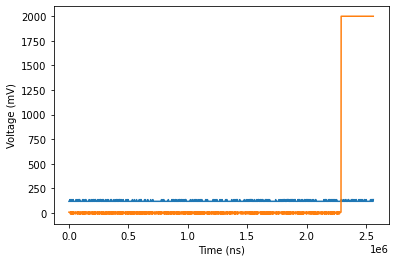

{'openUnit': 1, 'setChA': 1, 'setChB': 1, 'trigger': 1, 'getTimebase': 1, 'runBlock': 1, 'isReady': 1, 'getValues': 2000, 'stop': 1, 'close': 1}


In [1]:
#
# Copyright (C) 2018 Pico Technology Ltd. See LICENSE file for terms.
#
# PS2000 BLOCK MODE EXAMPLE
# This example opens a 2000 driver device, sets up two channels and a trigger then collects a block of data.
# This data is then plotted as mV against time in ns.

import ctypes
import numpy as np
from picosdk.ps2000 import ps2000 as ps
import matplotlib.pyplot as plt
from picosdk.functions import adc2mV, assert_pico2000_ok

# Create status ready for use
status = {}

# Open 2000 series PicoScope
# Returns handle to chandle for use in future API functions
status["openUnit"] = ps.ps2000_open_unit()
assert_pico2000_ok(status["openUnit"])

# Create chandle for use
chandle = ctypes.c_int16(status["openUnit"])

# Set up channel A
# handle = chandle
# channel = PS2000_CHANNEL_A = 0
# enabled = 1
# coupling type = PS2000_DC = 1
# range = PS2000_2V = 7
# analogue offset = 0 V
chARange = 7
status["setChA"] = ps.ps2000_set_channel(chandle, 0, 1, 1, chARange)
assert_pico2000_ok(status["setChA"])

# Set up channel B
# handle = chandle
# channel = PS2000_CHANNEL_B = 1
# enabled = 1
# coupling type = PS2000_DC = 1
# range = PS2000_2V = 7
# analogue offset = 0 V
chBRange = 7
status["setChB"] = ps.ps2000_set_channel(chandle, 1, 1, 1, chBRange)
assert_pico2000_ok(status["setChB"])

# Set up single trigger
# handle = chandle
# source = PS2000_CHANNEL_A = 0
# threshold = 1024 ADC counts
# direction = PS2000_RISING = 0
# delay = 0 s
# auto Trigger = 1000 ms
status["trigger"] = ps.ps2000_set_trigger(chandle, 0, 64, 0, 0, 1000)
assert_pico2000_ok(status["trigger"])

# Set number of pre and post trigger samples to be collected
preTriggerSamples = 1000
postTriggerSamples = 1000
maxSamples = preTriggerSamples + postTriggerSamples

# Get timebase information
# handle = chandle
# timebase = 8 = timebase
# no_of_samples = maxSamples
# pointer to time_interval = ctypes.byref(timeInterval)
# pointer to time_units = ctypes.byref(timeUnits)
# oversample = 1 = oversample
# pointer to max_samples = ctypes.byref(maxSamplesReturn)
timebase = 8
timeInterval = ctypes.c_int32()
timeUnits = ctypes.c_int32()
oversample = ctypes.c_int16(1)
maxSamplesReturn = ctypes.c_int32()
status["getTimebase"] = ps.ps2000_get_timebase(chandle, timebase, maxSamples, ctypes.byref(timeInterval), ctypes.byref(timeUnits), oversample, ctypes.byref(maxSamplesReturn))
assert_pico2000_ok(status["getTimebase"])

# Run block capture
# handle = chandle
# no_of_samples = maxSamples
# timebase = timebase
# oversample = oversample
# pointer to time_indisposed_ms = ctypes.byref(timeIndisposedms)
timeIndisposedms = ctypes.c_int32()
status["runBlock"] = ps.ps2000_run_block(chandle, maxSamples, timebase, oversample, ctypes.byref(timeIndisposedms))
assert_pico2000_ok(status["runBlock"])

# Check for data collection to finish using ps5000aIsReady
ready = ctypes.c_int16(0)
check = ctypes.c_int16(0)
while ready.value == check.value:
    status["isReady"] = ps.ps2000_ready(chandle)
    ready = ctypes.c_int16(status["isReady"])

# Create buffers ready for data
bufferA = (ctypes.c_int16 * maxSamples)()
bufferB = (ctypes.c_int16 * maxSamples)()

# Get data from scope
# handle = chandle
# pointer to buffer_a = ctypes.byref(bufferA)
# pointer to buffer_b = ctypes.byref(bufferB)
# poiner to overflow = ctypes.byref(oversample)
# no_of_values = cmaxSamples
cmaxSamples = ctypes.c_int32(maxSamples)
status["getValues"] = ps.ps2000_get_values(chandle, ctypes.byref(bufferA), ctypes.byref(bufferB), None, None, ctypes.byref(oversample), cmaxSamples)
assert_pico2000_ok(status["getValues"])

# find maximum ADC count value
maxADC = ctypes.c_int16(32767)

# convert ADC counts data to mV
adc2mVChA =  adc2mV(bufferA, chARange, maxADC)
adc2mVChB =  adc2mV(bufferB, chBRange, maxADC)

# Create time data
time = np.linspace(0, (cmaxSamples.value) * timeInterval.value, cmaxSamples.value)

# plot data from channel A and B
plt.plot(time, adc2mVChA[:])
plt.plot(time, adc2mVChB[:])
plt.xlabel('Time (ns)')
plt.ylabel('Voltage (mV)')
plt.show()

# Stop the scope
# handle = chandle
status["stop"] = ps.ps2000_stop(chandle)
assert_pico2000_ok(status["stop"])

# Close unitDisconnect the scope
# handle = chandle
status["close"] = ps.ps2000_close_unit(chandle)
assert_pico2000_ok(status["close"])

# display status returns
print(status)

In [8]:
not working
#
# Copyright (C) 2018 Pico Technology Ltd. See LICENSE file for terms.
#
# PS2000 ETS BLOCK MODE EXAMPLE
# This example opens a 2000 driver device, sets up two channels and a trigger with ETS mode then collects a block of data.
# This data is then plotted as mV against time in ns.

import ctypes
import numpy as np
from picosdk.ps2000 import ps2000 as ps
import matplotlib.pyplot as plt
from picosdk.functions import adc2mV, assert_pico2000_ok

# Create status ready for use
status = {}

# Open 2000 series PicoScope
# Returns handle to chandle for use in future API functions
status["openUnit"] = ps.ps2000_open_unit()
assert_pico2000_ok(status["openUnit"])

# Create chandle for use
chandle = ctypes.c_int16(status["openUnit"])

# Set up channel A
# handle = chandle
# channel = PS2000_CHANNEL_A = 0
# enabled = 1
# coupling type = PS2000_DC = 1
# range = PS2000_2V = 7
# analogue offset = 0 V
chARange = 7
status["setChA"] = ps.ps2000_set_channel(chandle, 0, 1, 1, chARange)
assert_pico2000_ok(status["setChA"])

# Set up channel B
# handle = chandle
# channel = PS2000_CHANNEL_B = 1
# enabled = 1
# coupling type = PS2000_DC = 1
# range = PS2000_2V = 7
# analogue offset = 0 V
chBRange = 7
status["setChB"] = ps.ps2000_set_channel(chandle, 1, 1, 1, chBRange)
assert_pico2000_ok(status["setChB"])

# Set up single trigger
# handle = chandle
# source = PS2000_CHANNEL_A = 0
# threshold = 1024 ADC counts
# direction = PS2000_RISING = 2
# delay = 0 s
# auto Trigger = 1000 ms
status["trigger"] = ps.ps2000_set_trigger(chandle, 0, 64, 2, 0, 1000)
assert_pico2000_ok(status["trigger"])

# Set up ets mode
# handle = chandle
# mode = PS2000_ETS_FAST = 1
# ets_cycles = 5
# ets_interleave = 5
status["setETS"] = ps.ps2000_set_ets(chandle, 1, 5, 5) 
assert_pico2000_ok(status["setETS"])

# Set number of pre and post trigger samples to be collected
preTriggerSamples = 0
postTriggerSamples = 500
maxSamples = preTriggerSamples + postTriggerSamples

# Get timebase information
# handle = chandle
# timebase = 8 = timebase
# no_of_samples = maxSamples
# pointer to time_interval = ctypes.byref(timeInterval)
# pointer to time_units = ctypes.byref(timeUnits)
# oversample = 1 = oversample
# pointer to max_samples = ctypes.byref(maxSamplesReturn)
timebase = 8
timeInterval = ctypes.c_int32()
timeUnits = ctypes.c_int32()
oversample = ctypes.c_int16(1)
maxSamplesReturn = ctypes.c_int32()
status["getTimebase"] = ps.ps2000_get_timebase(chandle, timebase, maxSamples, ctypes.byref(timeInterval), ctypes.byref(timeUnits), oversample, ctypes.byref(maxSamplesReturn))
assert_pico2000_ok(status["getTimebase"])

# Run block capture
# handle = chandle
# no_of_samples = maxSamples
# timebase = timebase
# oversample = oversample
# pointer to time_indisposed_ms = ctypes.byref(timeIndisposedms)
timeIndisposedms = ctypes.c_int32()
status["runBlock"] = ps.ps2000_run_block(chandle, maxSamples, timebase, oversample, ctypes.byref(timeIndisposedms))
assert_pico2000_ok(status["runBlock"])

# Check for data collection to finish using ps5000aIsReady
ready = ctypes.c_int16(0)
check = ctypes.c_int16(0)
while ready.value == check.value:
    status["isReady"] = ps.ps2000_ready(chandle)
    ready = ctypes.c_int16(status["isReady"])

# Create buffers ready for data
times = (ctypes.c_int16 * maxSamples)()
bufferA = (ctypes.c_int16 * maxSamples)()
bufferB = (ctypes.c_int16 * maxSamples)()
overflow = ctypes.c_int16(0)


# Get data from scope
# handle = chandle
# pointer to times = ctypes.byref(times)
# pointer to buffer_a = ctypes.byref(bufferA)
# pointer to buffer_b = ctypes.byref(bufferB)
# pointer to buffer c = None
# pointer to buffer d = None
# poiner to overflow = ctypes.byref(overflow)
# time_units = timeUnits.value
# no_of_values = cmaxSamples
cmaxSamples = ctypes.c_int32(maxSamples)
status["getValues"] = ps.ps2000_get_times_and_values(chandle, ctypes.byref(times), ctypes.byref(bufferA), ctypes.byref(bufferB), None, None, ctypes.byref(overflow), timeUnits.value, cmaxSamples)
assert_pico2000_ok(status["getValues"])

# find maximum ADC count value
maxADC = ctypes.c_int16(32767)

# convert ADC counts data to mV
adc2mVChA =  adc2mV(bufferA, chARange, maxADC)
adc2mVChB =  adc2mV(bufferB, chBRange, maxADC)

# Create time data
time = np.linspace(0, (cmaxSamples.value) * timeInterval.value, cmaxSamples.value)

# plot data from channel A and B
plt.plot(time, adc2mVChA[:])
plt.plot(time, adc2mVChB[:])
plt.xlabel('Time (ns)')
plt.ylabel('Voltage (mV)')
plt.show()

# Stop the scope
# handle = chandle
status["stop"] = ps.ps2000_stop(chandle)
assert_pico2000_ok(status["stop"])

# Close unitDisconnect the scope
# handle = chandle
status["close"] = ps.ps2000_close_unit(chandle)
assert_pico2000_ok(status["close"])

# display status returns
print(status)

NameError: name 'working' is not defined

In [7]:
# Stop the scope
# handle = chandle
status["stop"] = ps.ps2000_stop(chandle)
assert_pico2000_ok(status["stop"])

# Close unitDisconnect the scope
# handle = chandle
status["close"] = ps.ps2000_close_unit(chandle)
assert_pico2000_ok(status["close"])

# display status returns
print(status)

{'openUnit': 1, 'setChA': 1, 'setChB': 1, 'trigger': 1, 'setETS': 2000, 'getTimebase': 1, 'runBlock': 1, 'isReady': 0, 'stop': 1, 'close': 1}
